In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.datasets as dset
from data import image_manipulation
from data import dataloader as img_dataloader
from torch.autograd import Variable
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader

torch.cuda.is_available()

True

In [2]:
# random seed for reproducibility
random_seed = 69

np.random.seed(random_seed)

In [2]:
# no of workers for dataloader
no_of_workers = 4

# root of the data
data_root = "data/train/"

# batch size
batch_size = 1

#no of epochs
n_epochs = 10

# learning rate
lr = 0.0002

# betas for adam
beta_1 = 0.5
beta_2 = 0.999

# image size
image_height = 256
image_width = 256

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True,
                                         num_workers = no_of_workers)

In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [4]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize = True, dropout = 0.0):
        super(UNetDown, self).__init__()
        layers = [
            nn.Conv2d(in_size, out_size, 4, 2, 1, bias = False)
        ]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
            
        layers.append(nn.LeakyReLU(0.2))
        
        if dropout:
            layers.append(nn.Dropout(dropout))
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [5]:
class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout = 0.0):
        super(UNetUp, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)
        
    
    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

In [6]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        
        # unet connections
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

## Model Train

In [27]:
#initialize model classes
generator = GeneratorUNet()
discriminator = Discriminator()


# check if cuda is avialbale
cuda = True if torch.cuda.is_available() else False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(cuda)

# initialize weights if the model is not found in the paths
if os.path.exists("saved_models/generator_49.pth"):
    print("Generator Found")
    generator.load_state_dict(torch.load("saved_models/generator.pth", map_location = device))
else:
    generator.apply(weights_init_normal)
                                         
if os.path.exists("saved_models/discriminator_49.pth"):
    print("Discriminator Found")
    discriminator.load_state_dict(torch.load("saved_models/discriminator.pth", map_location = device))
else:
    discriminator.apply(weights_init_normal)

# model loss functions
loss_fn_generator = torch.nn.MSELoss() # mean squared loss
loss_fn_disc = torch.nn.L1Loss() #pixel wise loss

# to cuda if cuda is avaiable
generator.to(device)
discriminator.to(device)
loss_fn_disc.to(device)
loss_fn_generator.to(device)
    
# optimizers
optimier_G = torch.optim.Adam(generator.parameters(), betas=(beta_1, beta_2), lr=lr)
optimier_D = torch.optim.Adam(discriminator.parameters(), betas=(beta_1, beta_2), lr=lr)

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, image_height // 2 ** 4, image_width // 2 ** 4)
print(patch)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

True
Generator Found
Discriminator Found
(1, 16, 16)


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(), # transform to tensor
    transforms.Resize((512, 512)) # Resize the image to constant size
])

# create a dataloader
pair_image_dataloader = img_dataloader.ImageDataset("./data/train/old_images", "./data/train/reconstructed_images", transform)

dataloader = DataLoader(
    pair_image_dataloader,
    batch_size = 4,
    shuffle = True
)

val_pair_image_dataloader = img_dataloader.ImageDataset("./data/val/old_image", "./data/val/reconstructed_image", transform)

torch.cuda.empty_cache()

In [28]:
for epoch in range(10):
    for i, batch in tqdm(enumerate(dataloader)):
        real_A = batch['A'] # old image
        real_B = batch['B'] # new image
        
        # train generator
        optimier_G.zero_grad()
        
         # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False) # ground truth for valid
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False) # ground truth for invalid
        
        
        # GAN loss
        fake_B = generator(real_A.to(device)) # fake sample generated by generator
        pred_fake = discriminator(fake_B.to(device), real_B.to(device)) # prediction using discriminator
        loss_generator = loss_fn_generator(pred_fake.to(device), valid.to(device)) # check if the sample is valid or not
        
        loss_pixel = loss_fn_disc(fake_B.to(device), real_B.to(device)) # calculate the pixel wise loss
        
        # total loss
        loss_G = loss_generator + lambda_pixel * loss_pixel # total loss of the generator
        
        loss_G.backward()
        optimier_G.step()
        
        ## Train discriminator
        optimier_D.zero_grad()
        
        # Real loss
        pred_real = discriminator(real_B.to(device), real_A.to(device)) # loss to check real or not
        loss_real = loss_fn_generator(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach().to(device), real_A.to(device)) # loss to check fake or not
        loss_fake = loss_fn_generator(pred_fake.to(device), fake.to(device))

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake) # total loss of the discriminator
        
        loss_D.backward()
        optimier_D.step()
        
        # for logging
        print(f"Generator Error: {torch.linalg.norm(loss_G).item()}, epoch: {epoch}, itr: {i}")
        print(f"Discriminator Error: {torch.linalg.norm(loss_D).item()}, epoch: {epoch}, itr: {i}")
        
        # train with only 5000 images
        if i % 500 ==  0 and i > 0:
            break
            
        torch.cuda.empty_cache()

0it [00:00, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 5.80 GiB total capacity; 3.99 GiB already allocated; 422.81 MiB free; 4.01 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

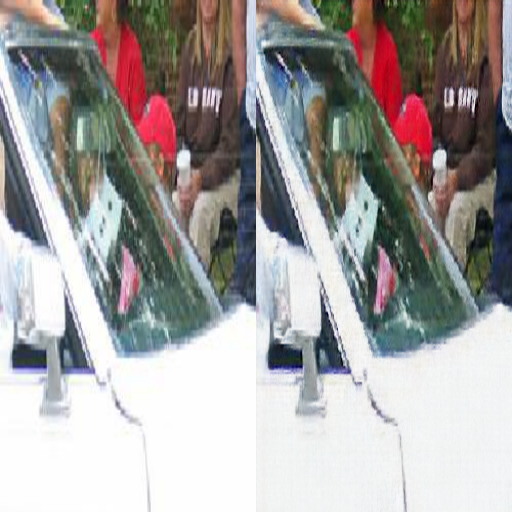

In [25]:
# generator.load_state_dict(torch.load("saved_models/generator_test.pth", map_location = device))
test_image_index = 124

generator.load_state_dict(torch.load("saved_models/generator_49.pth", map_location = device))
generated_image = generator(val_pair_image_dataloader[test_image_index]['A'].unsqueeze(0).to(device)).detach().cpu().numpy()[0]
output_image = image_manipulation.np_to_pil(
    generated_image
)
# print(torch.norm(discriminator(
#     generated_image, 
#     pair_image_dataloader[test_image_index]['B']
# )))
original_image = image_manipulation.np_to_pil(
    val_pair_image_dataloader[test_image_index]['A'].detach().cpu().numpy()
)

new_image = Image.new(output_image.mode, (512, 256))

new_image.paste(original_image, (0, 0))
new_image.paste(output_image, (256, 0))

new_image.resize((512, 512))

In [20]:

generator.load_state_dict(torch.load("saved_models/generator_mine.pth", map_location = device))

<All keys matched successfully>

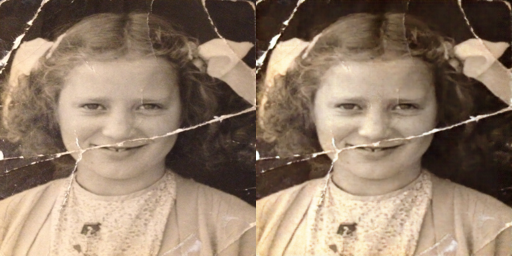

In [24]:
import requests
from io import BytesIO
link = "https://www.rootschat.com/forum/index.php?action=dlattach;topic=682420.0;attach=393468"
response = requests.get(link)
original_image = Image.open(BytesIO(response.content)).resize((256, 256))
output_image = image_manipulation.np_to_pil(
    generator(transform(original_image).unsqueeze(0).to(device)).detach().cpu().numpy()[0]
).resize((256, 256))

new_image = Image.new(output_image.mode, (256 * 2, 256))

new_image.paste(original_image, (0, 0))
new_image.paste(output_image, (256, 0))

new_image

In [28]:
torch.save(generator.state_dict(), "saved_models/generator.pth")
torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

In [95]:
os.path.exists("saved_models/generator.pth")

True